In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mobile_sam
import segment_anything

CHECKPOINTS = {"large" : r"src/sam_checkpoints/sam_vit_h_4b8939.pth",
               "medium": r"src/sam_checkpoints/sam_vit_l_0b3195.pth",
               "small" : r"src/sam_checkpoints/sam_vit_b_01ec64.pth",
               "mobile": r"src/sam_checkpoints/mobile_sam.pt"}

MODEL_TYPES = {"large" : "vit_h",
               "medium": "vit_l",
               "small" : "vit_b",
               "mobile": 'vit_t'}

class Segmenter:
    """
    Segmenter class to apply semantic segmentation to images using Meta's Segment Anything Model (SAM).

    Attributes:
        model (torch.Module): The loaded SAM model for image segmentation.
        mask_generator (SamAutomaticMaskGenerator): Utility for generating masks from the SAM model.
        device (str): The computing device used for model operations, e.g., 'cuda' or 'cpu'.
    """

    def __init__(self, checkpoint_path: str = None, model_type: str = None, model_size: str = "mobile", device: str = "cuda"):
        """
        Initialize Segmenter model and any utils.

        Arguments:
            checkpoint_path (str, optional): Path to SAM checkpoint for model.
            model_type (str, optional): Type of model in SAM checkpoint.
            model_size (str, "large"): Size of the model, options are 'large', 'medium', 'small', or 'mobile'.
            device (str, "cuda"): Device to run on; options are 'cuda' or 'cpu'.
        """
        # Determine pretrained model checkpoint and model type
        checkpoint, model_type = None, model_type
        if checkpoint_path and model_type:
            checkpoint = checkpoint_path
        else:
            checkpoint = CHECKPOINTS[model_size]
            model_type = MODEL_TYPES[model_size]

        # Determine if using SAM or MobileSAM
        if model_type == 'vit_t':
            sam_model_registry = mobile_sam.sam_model_registry
            SamAutomaticMaskGenerator = mobile_sam.SamAutomaticMaskGenerator
        else:
            sam_model_registry = segment_anything.sam_model_registry
            SamAutomaticMaskGenerator = segment_anything.SamAutomaticMaskGenerator
        
        # Load model
        self.model = sam_model_registry[model_type](checkpoint=checkpoint)
        self.model.to(device=device)

        # Initialize mask generator
        self.mask_generator = SamAutomaticMaskGenerator(self.model)

    def generate_masks(self, image: np.ndarray) -> list[dict]:
        """
        Generates masks of the image.

        Arguments:
            image (np.ndarray): Image represented in an array.

        Returns:
            list[dict]: A list of dictionaries representing each masked section of the image.
        """

        return self.mask_generator.generate(image)

    # TODO
    def is_valid_masks(self, masks: list[dict]) -> bool:
        """
        Checks if the masks list is a valid list of masks.

        Arguments:
            masks (list[dict]): List of dictionaries representing each masked section of the image.

        Returns:
            bool: Whether or not masks is a valid list.
        """

        return True

    def prepare_mask(self, mask: dict, is_bw: bool = False) -> np.ndarray:
        """
        Gets the image array of the mask.

        Arguments:
            image (np.ndarray): Image represented in an array.
            mask (dict): Dictionary representing the mask to prepare.
            is_bw (bool) : Whether or not mask overlay has black and white filter.

        Returns:
            np.ndarray: Image array of the prepared mask.
        """

        img = np.ones((mask['segmentation'].shape[0], mask['segmentation'].shape[1], 4))
        img[:,:,3] = 0

        m = mask['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask

        return img

    def prepare_masks(self, masks: list[dict], is_bw: bool = False) -> np.ndarray:
        """
        Gets the image array of a list of masks.

        Arguments:
            image (np.ndarray): Image represented in an array.
            masks (list[dict]): List of dictionaries representing each masked section of the image.
            is_bw (bool) : Whether or not mask overlay has black and white filter.

        Returns:
            np.ndarray: Image array of the prepared masks.
        """

        if len(masks) == 0:
            return
        sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

        img = np.ones((sorted_masks[0]['segmentation'].shape[0], sorted_masks[0]['segmentation'].shape[1], 4))
        img[:,:,3] = 0

        for mask in sorted_masks:
            m = mask['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask

        return img

    def visualize(self, mask_overlay: np.ndarray, image: np.ndarray, figsize: tuple[int] = (15, 5)):
        """
        Visualizes the mask. Overlays it on the image (if any).

        Arguments:
            mask_overlay (np.ndarray): Mask overlay image array.
            image (np.ndarray): Image represented in an array.
            figsize (tuple[int]): Matplotlib figure size.

        """

        is_bw = len(mask_overlay.shape) == 2

        # Display the original image
        plt.figure(figsize=figsize)
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        if is_bw:
            # Convert the mask to have 3 channels
            filter = np.stack([mask_overlay, mask_overlay, mask_overlay], axis=-1)

            # Apply the mask to the image
            masked_image = image * filter

            # Display the masked image
            plt.subplot(1, 3, 2)
            plt.imshow(masked_image)
            plt.title('Masked Image')
            plt.axis('off')

            # Display the mask overlay
            plt.subplot(1, 3, 3)
            plt.imshow(mask_overlay, cmap="gray")
            plt.title('Mask Overlay')
            plt.axis('off')
        else:
            # Display the masked image
            plt.subplot(1, 3, 2)
            plt.imshow(image)
            ax = plt.gca()
            ax.set_autoscale_on(False)
            ax.imshow(mask_overlay)
            plt.title('Masked Image')
            plt.axis('off')

            # Display the mask overlay
            plt.subplot(1, 3, 3)
            plt.imshow(mask_overlay)
            plt.title('Mask Overlay')
            plt.axis('off')

        plt.show()

    def convert_bw(self, mask_overlay: np.ndarray) -> np.ndarray:
        """
        Generate black and white filter on maks. Make any pixel not in overlay black
        and everything else white.

        Arguments:
            mask_overlay (np.ndarray) : Mask overlay image array

        Returns:
            np.ndarray : Black and white mask overlay
        """

        bw_overlay = np.all(mask_overlay[:, :, :3] == 1, axis=-1).astype(float)
        bw_overlay = np.where(bw_overlay==1., 0., 1.)

        return bw_overlay

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expect

In [2]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

REPO_NAME = "facebookresearch/dinov2"
MODEL_NAMES = {"large" : "dinov2_vitg14",
               "medium": "dinov2_vitl14",
               "small" : "dinov2_vitb14",
               "tiny"  : "dinov2_vits14"}

class DINOv2:
    """
    DINOv2 class uses Meta's DINOv2 model to extract feature embeddings of an image.

    Attributes:
        smaller_edge_size (int): Size of the smaller edge of the image for processing.
        half_precision (bool): Flag to indicate if half precision computation is used.
        device (str): Computing device, e.g., 'cuda' or 'cpu'.
        model (torch.Module): Loaded DINO model.
        transform (torchvision.transforms): Transformations applied to the input image.
    """

    def __init__(self,
                 model_size: str = "small",
                 smaller_edge_size: int = 448,
                 half_precision: bool = False,
                 device: str = "cuda"):
        """
        Initializes the Sparse_Matcher with specified parameters and loads the DINO model.

        Arguments:
            model_size (str, "small"): Size of the DINO model to load in terms of number of params
                'large' = 1.1 B
                'medium' = 300 M
                'small' = 86 M
                'tiny' = 21 M
            smaller_edge_size (int, 448): Size of the smaller edge of the image for processing.
            half_precision (bool, False): Whether to use half precision computation.
            device (str, "cuda"): The computing device, e.g., 'cuda' or 'cpu'.
        """

        self.smaller_edge_size = smaller_edge_size
        self.half_precision = half_precision
        self.device = device

        # Loading the DINO model with optional half precision.
        self.model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAMES[model_size])
        if self.half_precision:
            self.model = self.model.half()  # Convert to half precision if enabled
        self.model = self.model.to(self.device)  # Move model to specified device
        self.model.eval()  # Set model to evaluation mode

        # Transformations for input image preprocessing.
        self.transform = transforms.Compose([
            transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet defaults
            ])

    def prepare_image(self, rgb_image_numpy: np.ndarray) -> (torch.Tensor, tuple[int], float):
        """
        Prepares an RGB image for processing by resizing and cropping to fit the model's requirements.

        Arguments:
            rgb_image_numpy (numpy.ndarray): The RGB image in NumPy array format.

        Returns:
            Tuple containing the processed image tensor, grid size, and resize scale.
        """

        # Convert NumPy array to PIL image and apply transformations.
        image = Image.fromarray(rgb_image_numpy)
        image_tensor = self.transform(image)
        resize_scale = image.width / image_tensor.shape[2]  # Calculate scale of resize

        # Cropping the image to fit the model's input requirements.
        height, width = image_tensor.shape[1:]  # Extracting height and width
        # Ensure dimensions are multiples of the patch size.
        cropped_width = width - width % self.model.patch_size
        cropped_height = height - height % self.model.patch_size
        image_tensor = image_tensor[:, :cropped_height, :cropped_width]

        # Calculate grid size based on the cropped image dimensions.
        grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
        return image_tensor, grid_size, resize_scale

    def prepare_mask(self, mask_image_numpy: np.ndarray, grid_size: tuple[int], resize_scale: float) -> np.ndarray:
        """
        Prepares a mask image for processing, aligning it with the dimensions of the processed main image.

        Arguments:
            mask_image_numpy (numpy.ndarray): The mask image in NumPy array format.
            grid_size (tuple[int]): The grid size of the processed main image.
            resize_scale (float): The scale at which the main image was resized.

        Returns:
            NumPy array of the resized mask.
        """

        # Crop and resize mask to align with the processed image's grid.
        cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
        image = Image.fromarray(cropped_mask_image_numpy)
        resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
        resized_mask = np.asarray(resized_mask).flatten()  # Flatten the resized mask
        return resized_mask

    def extract_features(self, image_tensor: torch.Tensor) -> np.ndarray:
        """
        Extracts features from an image tensor using the DINOv2 model.

        Arguments:
            image_tensor (torch.Tensor): The image tensor to extract features from.

        Returns:
            NumPy array of extracted features.
        """


        # Perform inference without gradient calculation for efficiency.
        with torch.inference_mode():
            if self.half_precision:
                image_batch = image_tensor.unsqueeze(0).half().to(self.device)
            else:
                image_batch = image_tensor.unsqueeze(0).to(self.device)

            # Extracting features (tokens) from the image.
            tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
        return tokens.cpu().numpy()  # Return the extracted features as a NumPy array


    def idx_to_source_position(self, idx: int, grid_size: tuple, resize_scale: float) -> (int, int):
        """
        Converts an index in the flattened feature map back to its original position in the source image.

        Arguments:
            idx (int): The index in the flattened feature map.
            grid_size (tuple): The grid size of the processed image.
            resize_scale (float): The scale at which the original image was resized.

        Returns:
            Tuple of row and column indicating the position in the original image.
        """

        # Calculating the row and column in the original image from the index.
        row = (idx // grid_size[1]) * self.model.patch_size * resize_scale + self.model.patch_size / 2
        col = (idx % grid_size[1]) * self.model.patch_size * resize_scale + self.model.patch_size / 2
        return row, col

    def get_embedding_visualization(self, tokens: np.ndarray, grid_size: tuple, resized_mask: np.ndarray = None) -> np.ndarray:
        """
        Generates a visualization of the embeddings using PCA.

        Arguments:
            tokens (numpy.ndarray): The feature tokens extracted from the image.
            grid_size (tuple): The grid size of the processed image.
            resized_mask (numpy.ndarray, optional): The resized mask for selecting specific tokens.

        Returns:
            NumPy array representing the PCA-reduced and normalized tokens for visualization.
        """

        # Applying PCA to reduce the feature dimensions for visualization.
        pca = PCA(n_components=3)
        if resized_mask is not None:
            tokens = tokens[resized_mask]  # Apply mask if provided
        reduced_tokens = pca.fit_transform(tokens.astype(np.float32))

        # Reformatting tokens for visualization based on the resized mask.
        if resized_mask is not None:
            tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
            tmp_tokens[resized_mask] = reduced_tokens
            reduced_tokens = tmp_tokens
        reduced_tokens = reduced_tokens.reshape((*grid_size, -1))

        # Normalizing tokens for better visualization.
        normalized_tokens = (reduced_tokens - np.min(reduced_tokens)) / (np.max(reduced_tokens) - np.min(reduced_tokens))
        return normalized_tokens


In [3]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import binary_closing, binary_opening

class Sparse_Matcher:
    def __init__(self):
        pass

    def match_features(self, features1: np.ndarray, features2: np.ndarray) -> (np.ndarray, np.ndarray):
        knn = NearestNeighbors(n_neighbors=1)
        knn.fit(features1)
        distances, match2to1 = knn.kneighbors(features2)
        match2to1 = np.array(match2to1)

        return distances, match2to1

    def visualize(self,
                  dinov2: DINOv2,
                  image1: np.ndarray,
                  image2: np.ndarray,
                  mask1: np.ndarray,
                  mask2: np.ndarray,
                  grid_size1: tuple[int],
                  grid_size2: tuple[int],
                  resize_scale1: float,
                  resize_scale2: float,
                  distances: np.ndarray,
                  match2to1: np.ndarray,
                  figsize: tuple[int] = (20, 20),
                  show_percentage: float = 1):

        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.imshow(image1)
        ax1.axis("off")
        ax2.imshow(image2)
        ax2.axis("off")

        for idx2, (dist, idx1) in enumerate(zip(distances, match2to1)):
            row, col = dinov2.idx_to_source_position(idx1, grid_size1, resize_scale1)
            xyA = (col, row)
            if not mask1[int(row), int(col)]: continue # skip if feature is not on the object

            row, col = dinov2.idx_to_source_position(idx2, grid_size2, resize_scale2)
            xyB = (col, row)
            if not mask2[int(row), int(col)]: continue # skip if feature is not on the object

            if np.random.rand() > show_percentage: continue # sparsely draw so that we can see the lines...

            con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                                    axesA=ax2, axesB=ax1, color=np.random.rand(3,))
            ax2.add_artist(con)

In [4]:
# Load images
image1 = cv2.cvtColor(cv2.imread(r'tests/horse1.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread(r'tests/horse2.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

segmenter = Segmenter()
horse_masks1 = segmenter.generate_masks(image1)
horse_masks2 = segmenter.generate_masks(image2)

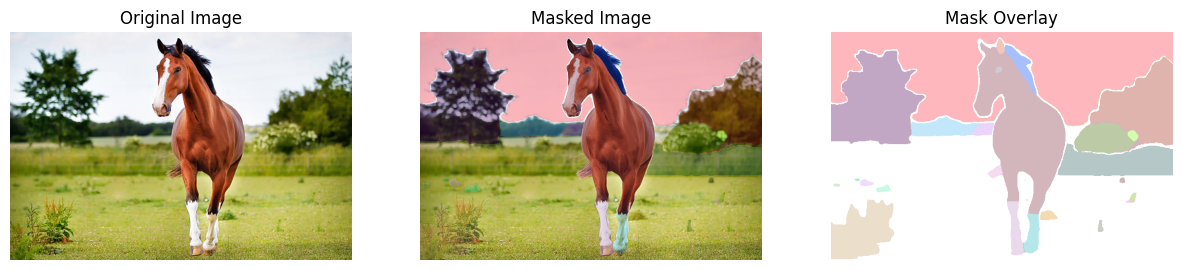

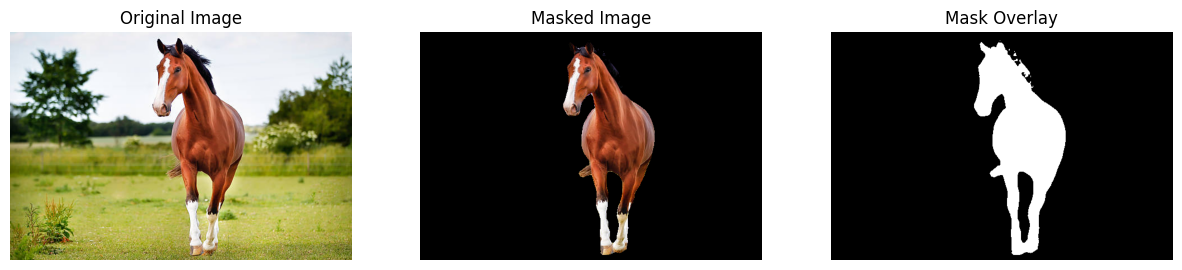

In [5]:
horse_mask1 = segmenter.prepare_masks(horse_masks1)
segmenter.visualize(horse_mask1, image1)

# for i in range(len(masks1)):
#     print(i)
#     horse_mask1 = segmenter.prepare_mask(masks1[i])
#     horse_mask1 = segmenter.convert_bw(horse_mask1).astype(bool)
#     segmenter.visualize(horse_mask1, image1)

idx = 1
horse_mask1 = segmenter.prepare_mask(horse_masks1[idx])
horse_mask1 = segmenter.convert_bw(horse_mask1).astype(bool)
segmenter.visualize(horse_mask1, image1)

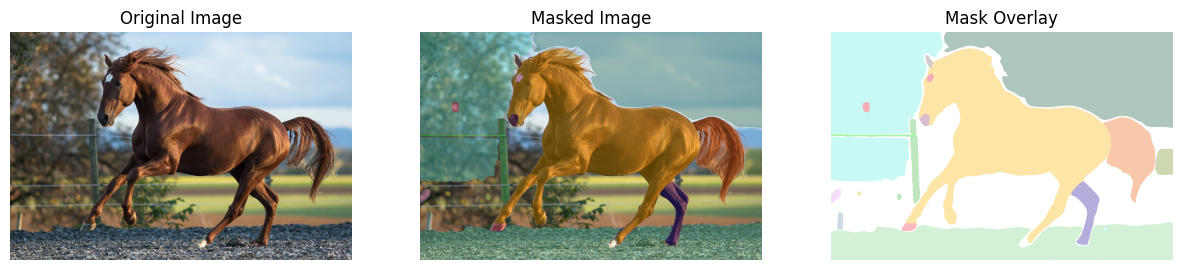

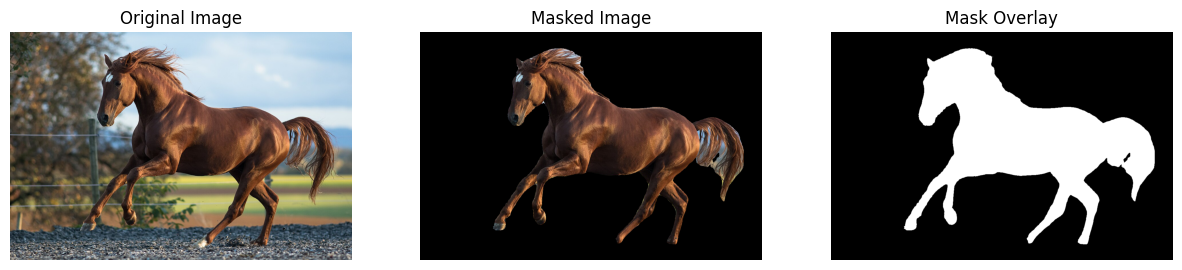

In [6]:
horse_mask2 = segmenter.prepare_masks(horse_masks2)
segmenter.visualize(horse_mask2, image2)

idx = 1
horse_mask2 = segmenter.prepare_mask(horse_masks2[idx])
horse_mask2 = segmenter.convert_bw(horse_mask2).astype(bool)
segmenter.visualize(horse_mask2, image2)

Using cache found in C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


(-0.5, 47.5, 31.5, -0.5)

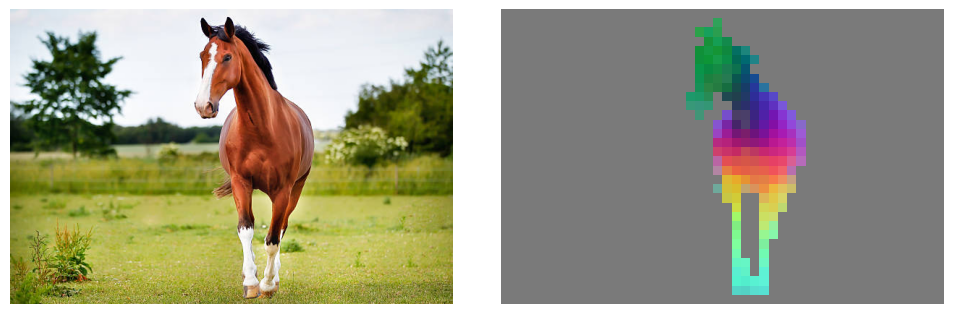

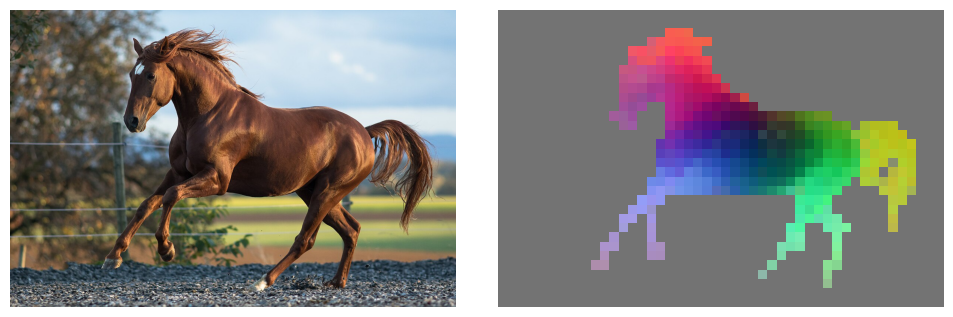

In [7]:
# Init Dinov2Matcher
dinov2 = DINOv2()
matcher = Sparse_Matcher()

# Extract image1 features
image_tensor1, grid_size1, resize_scale1 = dinov2.prepare_image(image1)
features1 = dinov2.extract_features(image_tensor1)

# Extract image2 features
image_tensor2, grid_size2, resize_scale2 = dinov2.prepare_image(image2)
features2 = dinov2.extract_features(image_tensor2)

# Visualization 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(image1)
resized_mask = dinov2.prepare_mask(horse_mask1, grid_size1, resize_scale1)
vis_image = dinov2.get_embedding_visualization(features1, grid_size1, resized_mask)
ax2.imshow(vis_image)
fig.tight_layout()
ax1.axis("off")
ax2.axis("off")

# Visualization 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(image2)
resized_mask = dinov2.prepare_mask(horse_mask2, grid_size2, resize_scale2)
vis_image = dinov2.get_embedding_visualization(features2, grid_size2, resized_mask)
ax2.imshow(vis_image)
fig.tight_layout()
ax1.axis("off")
ax2.axis("off")

In [8]:
# Build knn using features from image1, and query all features from image2
distances, match2to1 = matcher.match_features(features1, features2)

C:\Users\firdavs\AppData\Local\Temp\ipykernel_23792\2675080977.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if not mask1[int(row), int(col)]: continue # skip if feature is not on the object


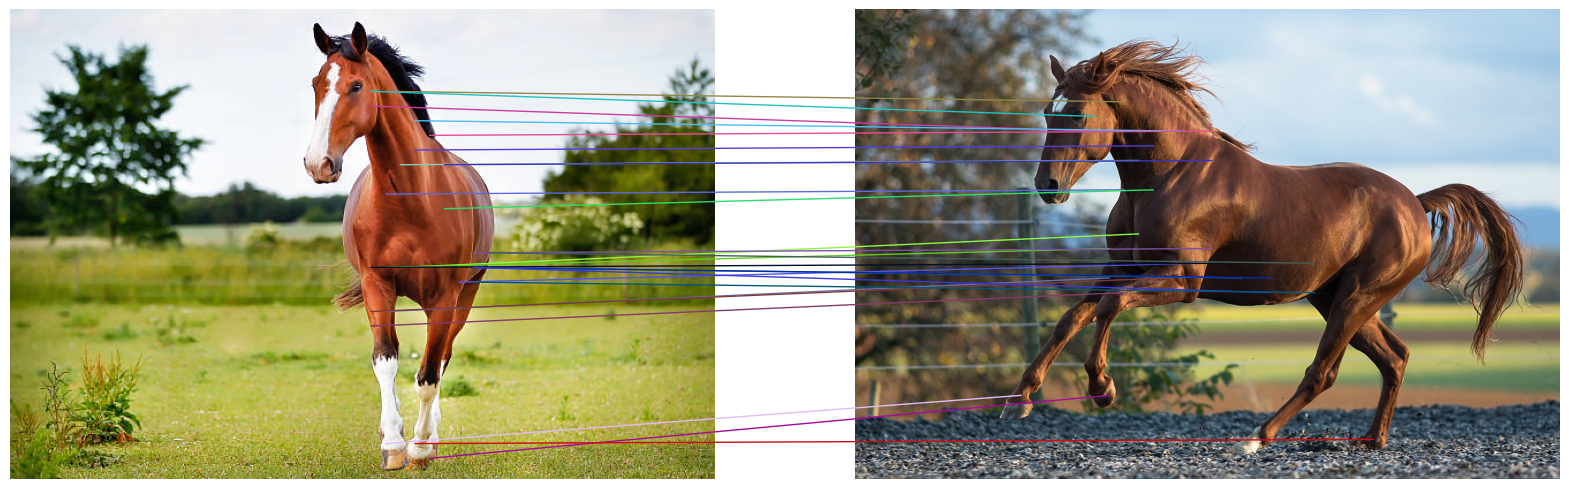

In [9]:
# Visualize sparse matching
matcher.visualize(dinov2,
                  image1, image2, horse_mask1, horse_mask2, grid_size1, grid_size2, resize_scale1, resize_scale2, distances, match2to1,
                  show_percentage = .1)

In [10]:
# Load images
image1 = cv2.cvtColor(cv2.imread(r'tests/asd1.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread(r'tests/asd2.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

segmenter = Segmenter()
dog_masks1 = segmenter.generate_masks(image1)
dog_masks2 = segmenter.generate_masks(image2)

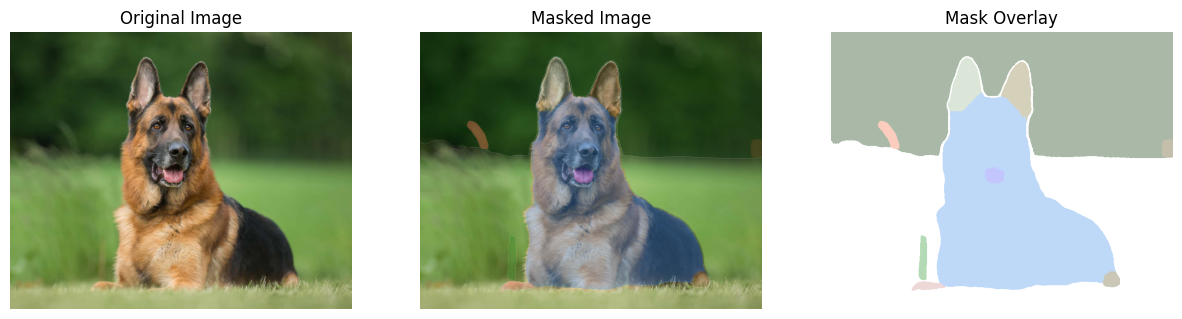

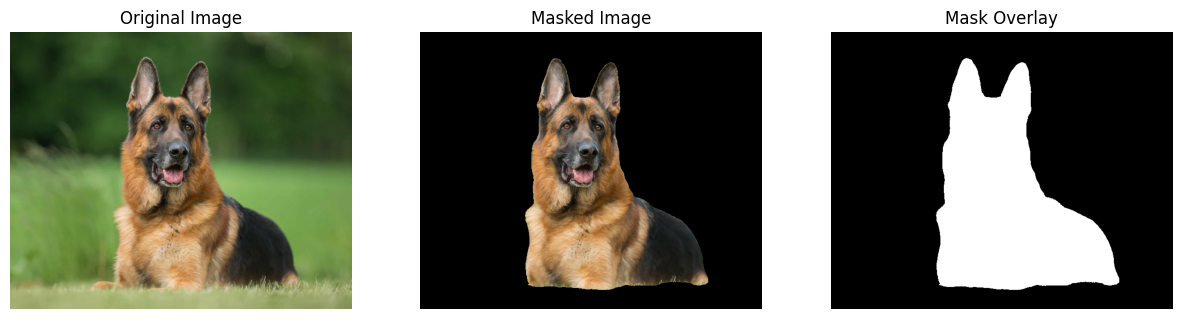

In [11]:
dog_mask1 = segmenter.prepare_masks(dog_masks1)
segmenter.visualize(dog_mask1, image1)

idx = 1
dog_mask1 = segmenter.prepare_mask(dog_masks1[idx])
dog_mask1 = segmenter.convert_bw(dog_mask1).astype(bool)
segmenter.visualize(dog_mask1, image1)

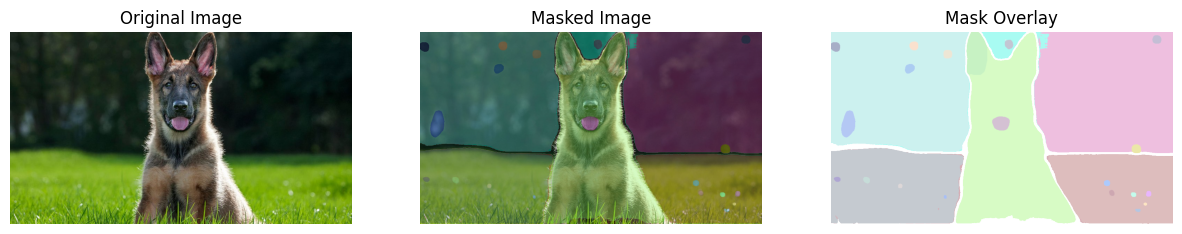

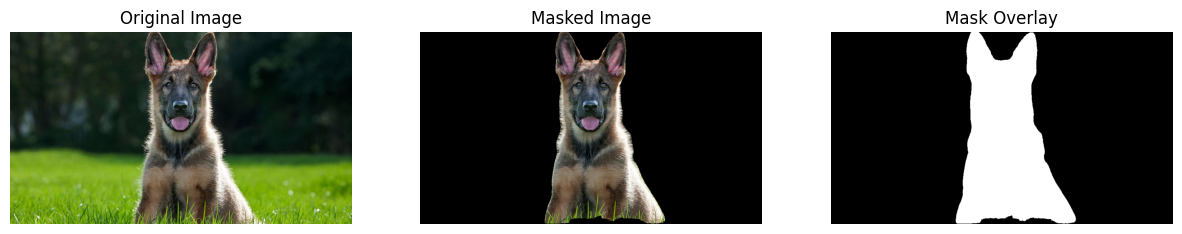

In [12]:
dog_mask2 = segmenter.prepare_masks(dog_masks2)
segmenter.visualize(dog_mask2, image2)

idx = 2
dog_mask2 = segmenter.prepare_mask(dog_masks2[idx])
dog_mask2 = segmenter.convert_bw(dog_mask2).astype(bool)
segmenter.visualize(dog_mask2, image2)

Using cache found in C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main


(-0.5, 55.5, 31.5, -0.5)

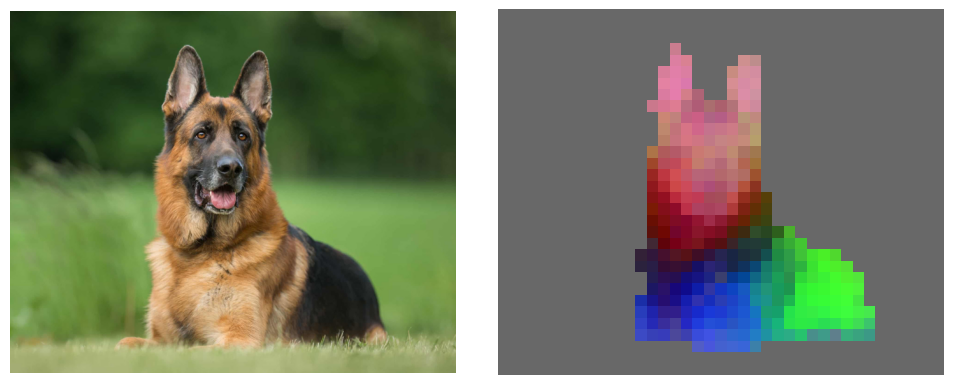

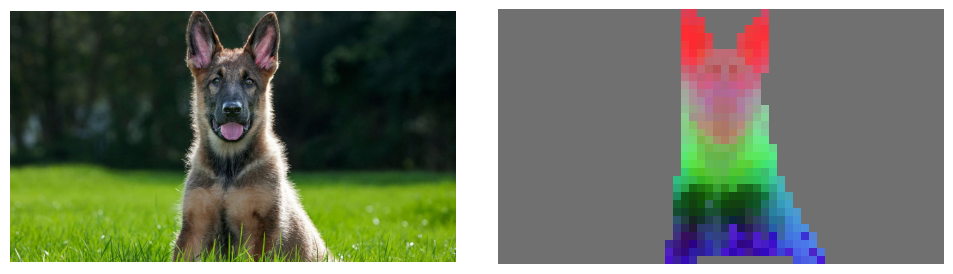

In [13]:
# Init Dinov2Matcher
dinov2 = DINOv2()
matcher = Sparse_Matcher()

# Extract image1 features
image_tensor1, grid_size1, resize_scale1 = dinov2.prepare_image(image1)
features1 = dinov2.extract_features(image_tensor1)

# Extract image2 features
image_tensor2, grid_size2, resize_scale2 = dinov2.prepare_image(image2)
features2 = dinov2.extract_features(image_tensor2)

# Visualization 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(image1)
resized_mask = dinov2.prepare_mask(dog_mask1, grid_size1, resize_scale1)
vis_image = dinov2.get_embedding_visualization(features1, grid_size1, resized_mask)
ax2.imshow(vis_image)
fig.tight_layout()
ax1.axis("off")
ax2.axis("off")

# Visualization 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(image2)
resized_mask = dinov2.prepare_mask(dog_mask2, grid_size2, resize_scale2)
vis_image = dinov2.get_embedding_visualization(features2, grid_size2, resized_mask)
ax2.imshow(vis_image)
fig.tight_layout()
ax1.axis("off")
ax2.axis("off")

In [14]:
# Build knn using features from image1, and query all features from image2
distances, match2to1 = matcher.match_features(features1, features2)

C:\Users\firdavs\AppData\Local\Temp\ipykernel_23792\2675080977.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if not mask1[int(row), int(col)]: continue # skip if feature is not on the object


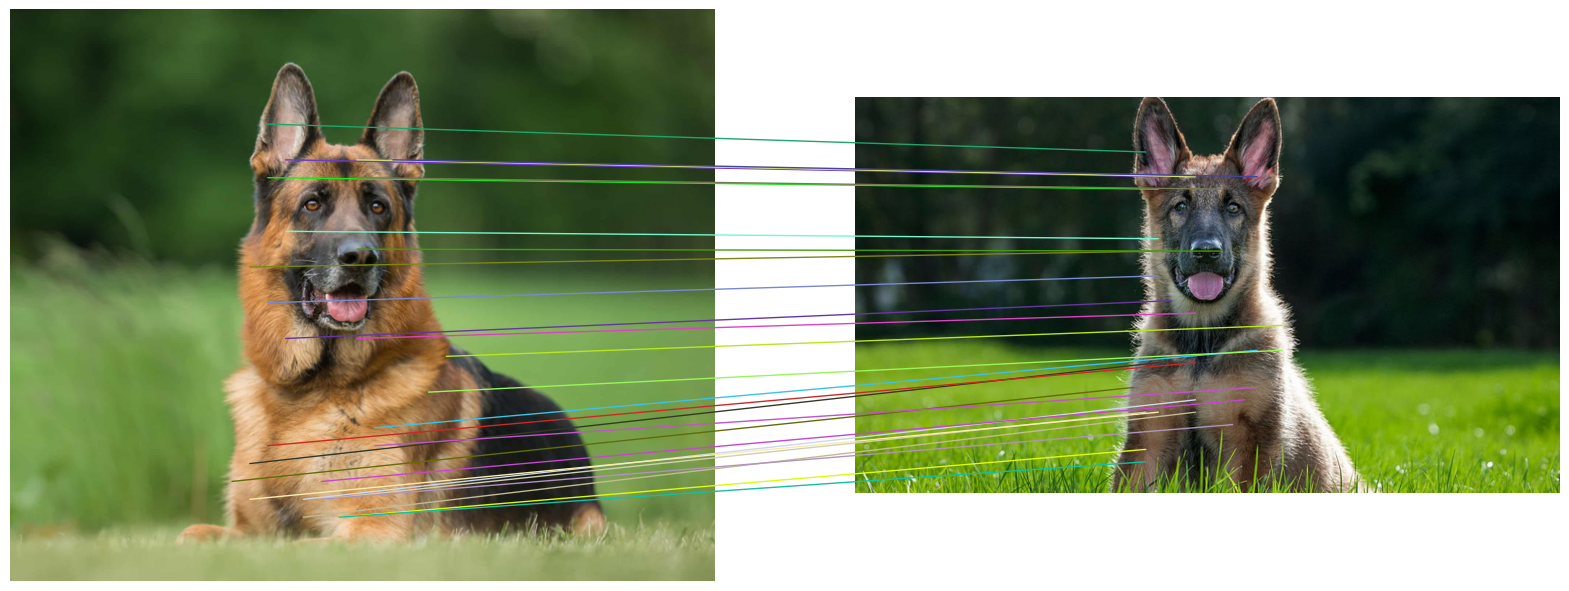

In [15]:
# Visualize sparse matching
matcher.visualize(dinov2,
                  image1, image2, dog_mask1, dog_mask2, grid_size1, grid_size2, resize_scale1, resize_scale2, distances, match2to1,
                  show_percentage = .1)

# Timings

In [16]:
### Segmenter ###
image = cv2.cvtColor(cv2.imread('tests/horse1.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

segmenter_mobile = Segmenter(model_size="mobile")
segmenter_small  = Segmenter(model_size="small")
segmenter_medium = Segmenter(model_size="medium")
segmenter_large  = Segmenter(model_size="large")

In [17]:
from tqdm import tqdm
import time

num_runs = 10
time_averages_sam = {"mobile": 0, "small": 0, "medium": 0, "large": 0}

for segmenter, model_size in zip([segmenter_mobile, segmenter_small, segmenter_medium, segmenter_large], ["mobile", "small", "medium", "large"]):
    print(model_size)
    for i in tqdm(range(num_runs)):
        start = time.time()
        segmenter.generate_masks(image)
        end  = time.time()
        time_averages_sam[model_size] += end - start

for key in time_averages_sam:
    time_averages_sam[key] /= num_runs

for model_size, time_avg in time_averages_sam.items():
    print(f"{model_size}:\t{round(time_avg, 3)}")

mobile


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


small


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


medium


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


large


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]

mobile:	1.357
small:	1.396
medium:	1.854
large:	2.119


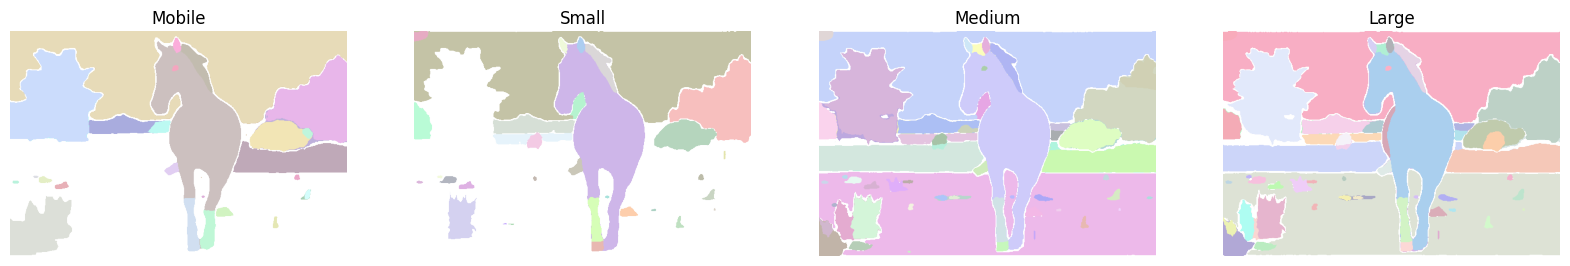

In [18]:
masks_mobile = segmenter_mobile.generate_masks(image)
masks_small  = segmenter_small.generate_masks(image)
masks_medium = segmenter_medium.generate_masks(image)
masks_large  = segmenter_large.generate_masks(image)

overlay_mobile = segmenter_mobile.prepare_masks(masks_mobile)
overlay_small  = segmenter_small.prepare_masks(masks_small)
overlay_medium = segmenter_medium.prepare_masks(masks_medium)
overlay_large  = segmenter_large.prepare_masks(masks_large)

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(overlay_mobile)
plt.title('Mobile')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(overlay_small)
plt.title('Small')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(overlay_medium)
plt.title('Medium')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlay_large)
plt.title('Large')
plt.axis('off')

plt.show()

In [19]:
### DINOv2 ###
image = cv2.cvtColor(cv2.imread(r'tests/horse1.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

d_tiny = DINOv2(model_size="tiny")
d_small = DINOv2(model_size="small")
d_medium = DINOv2(model_size="medium")
d_large = DINOv2(model_size="large")

Using cache found in C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\firdavs/.cache\torch\hub\facebookresearch_dinov2_main


In [20]:
from tqdm import tqdm
import time

num_runs = 100
time_averages_dino = {"tiny": 0, "small": 0, "medium": 0, "large": 0}

for d, model_size in zip([d_tiny, d_small, d_medium, d_large], ["tiny", "small", "medium", "large"]):
    print(model_size)
    for i in tqdm(range(num_runs)):
        start = time.time()
        image_tensor, grid_size, resize_scale = d.prepare_image(image)
        features = d.extract_features(image_tensor)
        end = time.time()
        time_averages_dino[model_size] += end - start

for key in time_averages_dino:
    time_averages_dino[key] /= num_runs

for model_size, time_avg in time_averages_dino.items():
    print(f"{model_size}:\t{round(time_avg, 3)}")

tiny


100%|██████████| 100/100 [00:01<00:00, 54.73it/s]


small


100%|██████████| 100/100 [00:03<00:00, 32.75it/s]


medium


100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


large


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]

tiny:	0.018
small:	0.03
medium:	0.078
large:	0.227


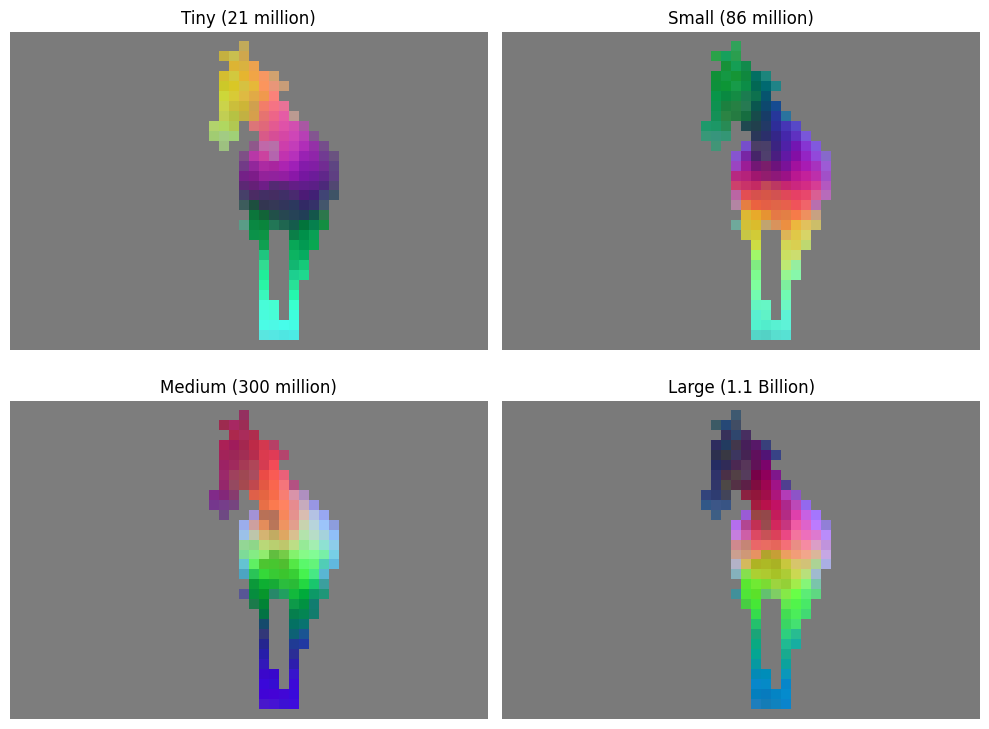

In [21]:
plt.figure(figsize=(10, 10))

image_tensor, grid_size, resize_scale = d_tiny.prepare_image(image)
features = d_tiny.extract_features(image_tensor)
resized_mask = d_tiny.prepare_mask(horse_mask1, grid_size, resize_scale)
vis_image = d_tiny.get_embedding_visualization(features, grid_size, resized_mask)
plt.subplot(2, 2, 1)
plt.imshow(vis_image)
plt.title("Tiny (21 million)")
plt.axis("Off")

image_tensor, grid_size, resize_scale = d_small.prepare_image(image)
features = d_small.extract_features(image_tensor)
resized_mask = d_small.prepare_mask(horse_mask1, grid_size, resize_scale)
vis_image = d_small.get_embedding_visualization(features, grid_size, resized_mask)
plt.subplot(2, 2, 2)
plt.imshow(vis_image)
plt.title("Small (86 million)")
plt.axis("Off")

image_tensor, grid_size, resize_scale = d_medium.prepare_image(image)
features = d_medium.extract_features(image_tensor)
resized_mask = d_medium.prepare_mask(horse_mask1, grid_size, resize_scale)
vis_image = d_medium.get_embedding_visualization(features, grid_size, resized_mask)
plt.subplot(2, 2, 3)
plt.imshow(vis_image)
plt.title("Medium (300 million)")
plt.axis("Off")

image_tensor, grid_size, resize_scale = d_large.prepare_image(image)
features = d_large.extract_features(image_tensor)
resized_mask = d_large.prepare_mask(horse_mask1, grid_size, resize_scale)
vis_image = d_large.get_embedding_visualization(features, grid_size, resized_mask)
plt.subplot(2, 2, 4)
plt.imshow(vis_image)
plt.title("Large (1.1 Billion)")
plt.axis("Off")

plt.tight_layout(h_pad=-10)
plt.show()